In [ ]:
!conda install -c intel scikit-learn

# Training a sentiment analysis classifier based on supervised machine learning algorithms

In [1]:
import string

import pymongo

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

import pandas as pd

In [2]:
stop_words = set(stopwords.words('spanish'))

In [3]:
# MongoDB connection data
HOST = 'localhost'
PORT = '27017'
DB_NAME = 'trending'

### Connecting to database

In [4]:
db = None
try:
    db_client = pymongo.MongoClient(HOST + ':' + PORT)
    db = db_client[DB_NAME]
    print('Conecction established successfully!')
except pymongo.errors.ConnectionFailure:
    print('Connection cannot be established')

Conecction established successfully!


In [5]:
HISTORY_COL = db['history']

### Getting all texts and removing duplicates

In [6]:
tweets = HISTORY_COL.find({}, {'_id': 0, 'full_text': 1})

In [7]:
tweets_df =  pd.DataFrame(list(tweets))

In [8]:
tweets_df.shape

(29700, 1)

In [9]:
tweets_df['full_text'] = tweets_df['full_text'].str.replace('RT ', '')

In [10]:
tweets_df.drop_duplicates(inplace = True)

In [11]:
tweets_df.shape

(6036, 1)

In [12]:
tweets_df['sentiment'] = None

In [13]:
tweets_df.head()

,full_text,sentiment
0,@hugouribev: @isamg6 @MOinternationa @petrogus...,None
1,"@maridelas18: Fueraaa, Petro de Medellín",None
2,@MunozEnith: Medellín se lució hoy. El repudio...,None
3,@isamg6: La historia contará que en Medellín s...,None
4,@funurbiano: Los del asalto a la fundidora de ...,None


### Labeling

In [14]:
tweets_df.to_csv('./data/medellin_tweets.csv', index = False, sep = '|')

<br />
<span style="color: red;">Labeling...</span>
<br /><br />

In [15]:
tweets_df = pd.read_csv('./data/medellin_tweets_labeled.csv', sep = ',')

In [16]:
tweets_df.head()

,full_text,sentiment
0,@hugouribev: @isamg6 @MOinternationa @petrogus...,0.0
1,"@maridelas18: Fueraaa, Petro de Medellín",0.0
2,@MunozEnith: Medellín se lució hoy. El repudio...,0.0
3,@isamg6: La historia contará que en Medellín s...,0.0
4,@funurbiano: Los del asalto a la fundidora de ...,1.0


In [18]:
tweets_df['sentiment'].value_counts(dropna = False)

NaN    5723
0.0     175
1.0     138
Name: sentiment, dtype: int64

In [17]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

NaN    0.948144
0.0    0.028993
1.0    0.022863
Name: sentiment, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [19]:
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [20]:
tweets_labeled_df.shape

(313, 2)

In [21]:
tweets_nolabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [22]:
tweets_nolabeled_df.shape

(5723, 2)

### Vectorizing text using BOW

<img src="./imgs/bow.png" style="height: 250px;">

In [23]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

In [24]:
vectorizer = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [26]:
X = vectorizer.fit_transform(tweets_labeled_df['full_text'])

In [30]:
vectorizer.get_feature_names()[:10]

['!',
 '"',
 '#',
 '#4nov',
 '#94-63',
 '#actualidad',
 '#alerta',
 '#alumbradosepm',
 '#avenidalasvegas',
 '#bodegadeoro']

### Splitting train and test datasets

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, tweets_labeled_df['sentiment'], test_size = 0.3, stratify = tweets_labeled_df['sentiment'], random_state = 1)

In [32]:
pd.Series(y_train).value_counts(normalize = True)

0.0    0.557078
1.0    0.442922
Name: sentiment, dtype: float64

In [33]:
pd.Series(y_test).value_counts(normalize = True)

0.0    0.56383
1.0    0.43617
Name: sentiment, dtype: float64

### Training a first model

In [34]:
logistic_model = LogisticRegression(random_state = 2)

In [35]:
logistic_model.fit(X_train, y_train)

LogisticRegression(random_state=2)

In [36]:
y_train_predict = logistic_model.predict(X_train)
y_test_predict = logistic_model.predict(X_test)

### Validating how this first model behaves

<img src="./imgs/confusion-matrix.png" style="height: 300px;">

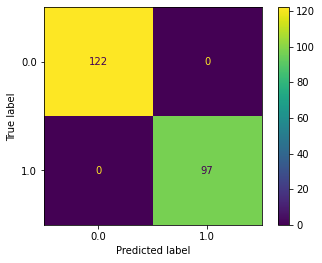

In [37]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_predict)

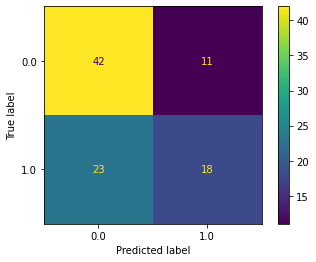

In [38]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict)

<img src="./imgs/precision-recall.png" style="height: 700px;">

In [39]:
print(precision_score(y_test, y_test_predict))
print(recall_score(y_test, y_test_predict))
print(f1_score(y_test, y_test_predict))

0.6206896551724138
0.43902439024390244
0.5142857142857142


### Next steps

- Vectorize words using TF-IDF:

<img src="./imgs/tf-idf.png" style="height: 350px;">

- Test different algorithms: árboles de decision (random forest), support vector machines, otros.
- ¿Which model is better and why?